In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import cycle, islice

In [59]:
def get_membrane_blebbing_data(experiment_folder, istest=False):
    """generate box plot to compare conditions or summarize experiment"""
    subdirs = os.listdir(experiment_folder);
    experiment_title = os.path.basename(experiment_folder)
    if not all(["output" in dirname for dirname in subdirs]):
        condition_labels = subdirs;
    else:
        condition_labels = [experiment_title];
    dfs = []
    for condition in condition_labels:
        if (len(condition_labels) == 1) and condition_labels[0] == experiment_title:
            data_folder = experiment_folder;
        else:
            data_folder = os.path.join(experiment_folder, condition);
        for subfolder in os.listdir(data_folder):
            df = pd.read_csv(os.path.join(data_folder, subfolder, "Intensity ratios.csv"));
            df['output_folder'] = subfolder;
            df['Condition'] = condition;
            if istest:
                df['outer/inner'] = np.random.normal(loc=df['outer/inner'], scale=df['outer/inner'].std())
            dfs.append(df);
    conditionwise_data = pd.concat(dfs, ignore_index=True);
    return conditionwise_data
        
def color_cycle(base_list_of_colors=['r', 'g', 'b', 'y', 'm', 'c'], l=6):
    """Return a list of colors of length l, looping where necessary"""
    return list(islice(cycle(base_list_of_colors), None, l));

def plot_time_dependence_by_condition(df, istest=False):
    """generate line plot showing evolution of intensity ration with time, per condition"""
    conditions = df['Condition'].unique();
    clrs = color_cycle(l=len(conditions));
    if istest:
        for idx, condition in enumerate(conditions):
            df.loc[(df['Condition'] == condition), 'outer/inner'] = df.loc[(df['Condition'] == condition), 'outer/inner']+idx/5;
    ax = df.groupby(['Condition', 'Frame']).median()['outer/inner'].unstack(level=0).plot(color=clrs);
    ax.set_ylabel("Actin intensity ratio");
    for idx, condition in enumerate(conditions):
        ax.fill_between(df.groupby('Frame')['Frame'].mean(), 
                    df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0)[condition], 
                    df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0)[condition], 
                    color=clrs[idx], alpha=0.2)
    ax.set_title("Time evolution of actin intensity ratios");
    box = ax.get_position();
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

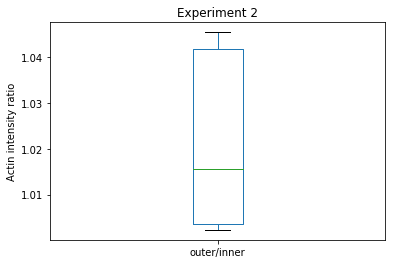

In [66]:
# test
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
ax = df.groupby('output_folder').mean().boxplot(column='outer/inner', grid=False)
ax.set_ylabel("Actin intensity ratio");
ax.set_title(os.path.basename(experiment_folder));


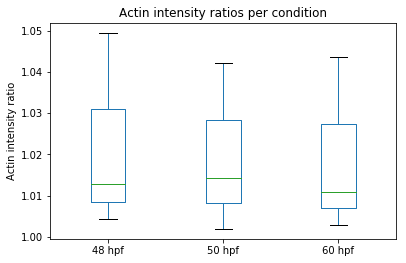

In [69]:
# test2
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
#print(df)
summary = df.groupby('output_folder').mean();
sub = df.drop_duplicates('output_folder');
summary['Condition'] = sub.set_index('output_folder')['Condition'];
ax = summary.boxplot(column='outer/inner', by='Condition', grid=False);
ax.set_ylabel("Actin intensity ratio");
ax.set_xlabel('');
plt.suptitle('')
ax.set_title("Actin intensity ratios per condition");

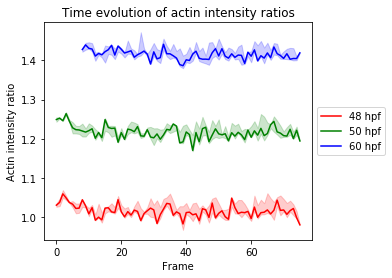

In [70]:
# test3   
experiment_folder = "D:\\data\\Joyce data test\\Dummy experiment 2"
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
plot_time_dependence_by_condition(df, istest=True)

#df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);
#df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);

#print(df[df['Condition'] == '60 hpf'])


In [35]:
lst = [1, 2, 3];
if not lst:
    print("empty")
else:
    print(len(lst))

3


In [54]:
df.loc[(df['Condition'] == '48 hpf'), 'outer/inner'] = df.loc[(df['Condition'] == '48 hpf'), 'outer/inner']+1
print(df['outer/inner'])

0      3.045438
1      3.017563
2      3.053384
3      3.037283
4      3.025080
5      3.003063
6      3.031734
7      3.029226
8      3.032816
9      3.010764
10     3.030562
11     3.046871
12     3.026463
13     3.035164
14     2.999046
15     3.022202
16     2.999127
17     3.041986
18     3.033543
19     2.994846
20     3.016504
21     3.046028
22     3.028902
23     3.012475
24     3.101021
25     3.036118
26     3.083783
27     3.017586
28     3.029669
29     3.061545
         ...   
624    0.973340
625    0.979507
626    1.006617
627    0.973723
628    0.995583
629    1.003801
630    1.003861
631    0.972282
632    1.005374
633    0.987900
634    1.008346
635    1.004925
636    1.000549
637    1.014335
638    0.993146
639    1.007706
640    1.016253
641    1.018109
642    0.992381
643    1.014138
644    1.006194
645    1.020517
646    1.020817
647    1.000451
648    1.024949
649    1.003661
650    0.998193
651    0.991409
652    1.007107
653    1.000494
Name: outer/inner, Lengt